In [250]:
import cv2 as cv
from matplotlib import pyplot as plt

In [270]:
import rasterio
import geopandas as gpd
from shapely.geometry import box

# Step 1: Load the TIFF file
tif_path = 'lake_morat.tif'
with rasterio.open(tif_path) as src:
    # Step 2: Get the bounding box of the raster
    bbox = src.bounds  # (min_x, min_y, max_x, max_y)

# The bbox is in the format (min_x, min_y, max_x, max_y)
min_x, min_y, max_x, max_y = bbox

# Step 3: Create a bounding box polygon in the original CRS of the raster
bbox_polygon = box(min_x, min_y, max_x, max_y)
gdf = gpd.GeoDataFrame({"geometry": [bbox_polygon]}, crs=src.crs)

# Step 4: Transform the GeoDataFrame to EPSG:2056
gdf_2056 = gdf.to_crs("EPSG:2056")

# Step 5: Calculate the area in square meters
area_sqm = gdf_2056.geometry.area.iloc[0]
print(f"Area of the extents in square meters (EPSG:2056): {area_sqm:.2f} m²")


Area of the extents in square meters (EPSG:2056): 55979388.11 m²


(5538, 7154, 3)


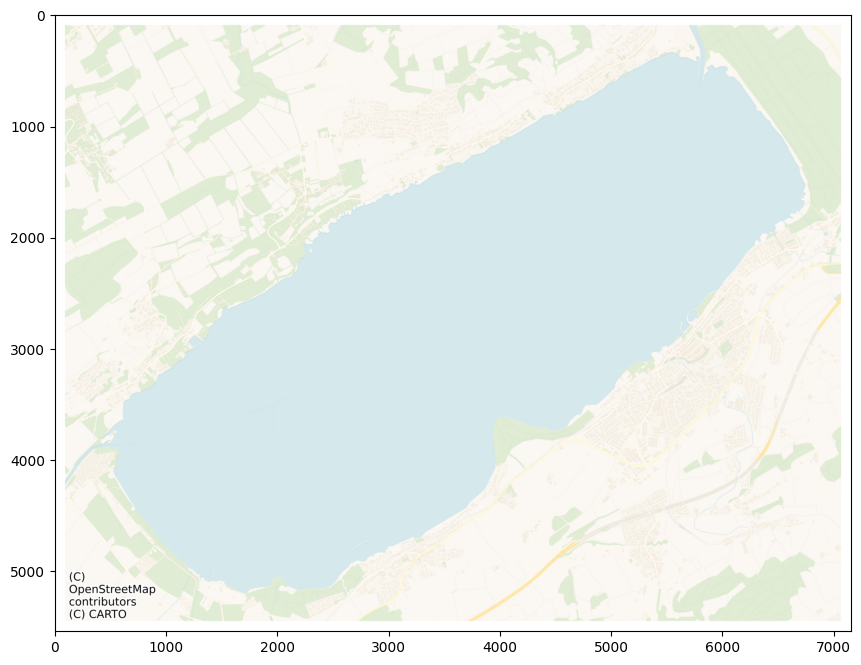

In [252]:
img = cv.imread('lake_morat_temp.png')
#convert to RGB
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
print(img.shape)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(img)

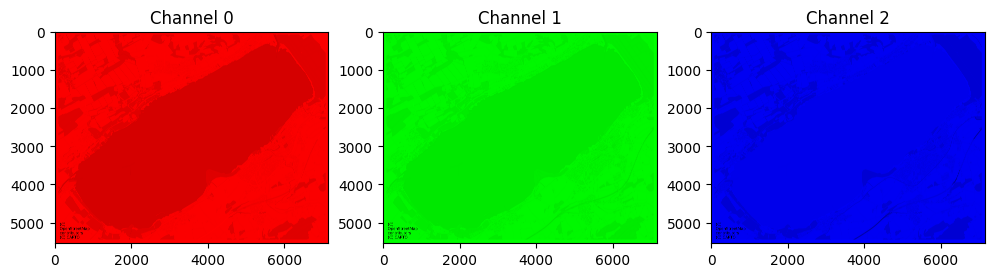

In [253]:
#create 3 subplots for each channel
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for i in range(3):
    temp = img.copy()
    for j in range(3):
        if j != i:
            temp[:,:,j] = 0
    ax[i].imshow(temp)
    ax[i].set_title('Channel ' + str(i))
plt.show()

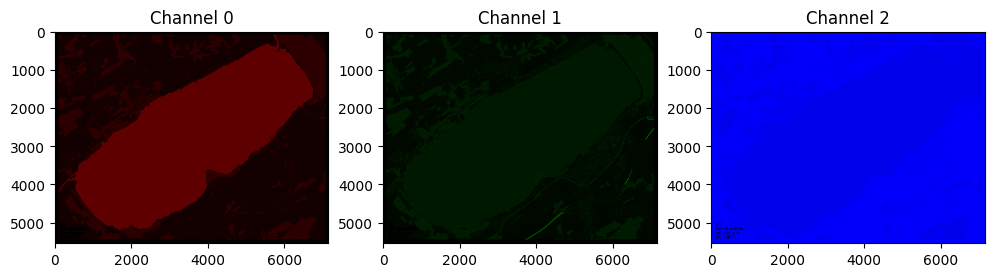

In [254]:
#transform to hsv
img_hsv = cv.cvtColor(img, cv.COLOR_RGB2HSV)
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
for i in range(3):
    temp = img_hsv.copy()
    for j in range(3):
        if j != i:
            temp[:,:,j] = 0
    ax[i].imshow(temp)
    ax[i].set_title('Channel ' + str(i))
plt.show()

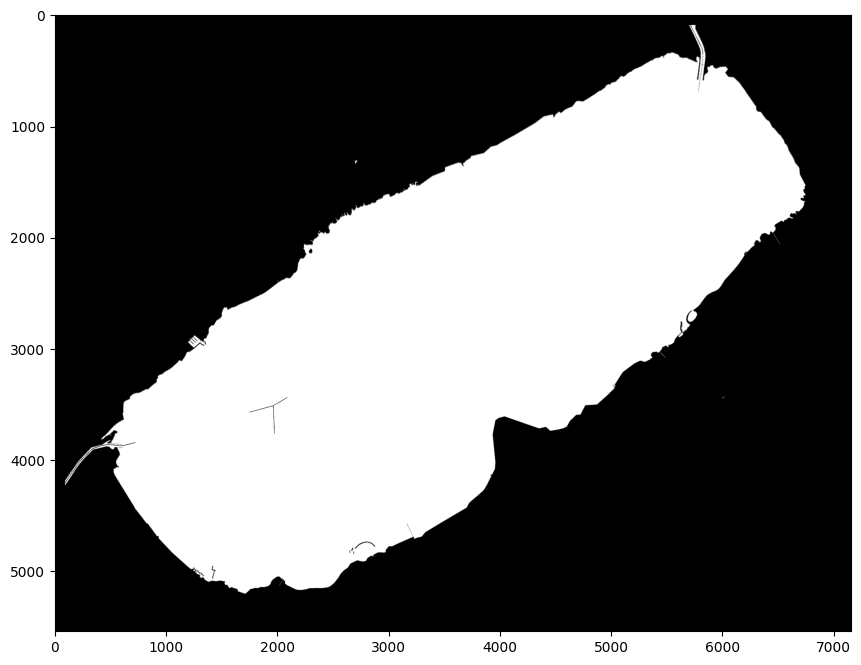

In [255]:
#binarize by hue channel
hue = img_hsv[:,:,0]
bin_og = cv.inRange(hue, 94, 94)

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(bin_og, cmap='gray')
plt.show()

In [256]:
# #binarize by rgb channels for this color 213,232,235
# r = img[:,:,0]
# g = img[:,:,1]
# b = img[:,:,2]
# bin_og = cv.inRange(r, 213, 213) & cv.inRange(g, 232, 232) & cv.inRange(b, 235, 235)

# fig, ax = plt.subplots(1, 1, figsize=(12, 8))
# ax.imshow(bin_og, cmap='gray')
# plt.show()

Number of objects: 1354
Size of biggest object: 14995352


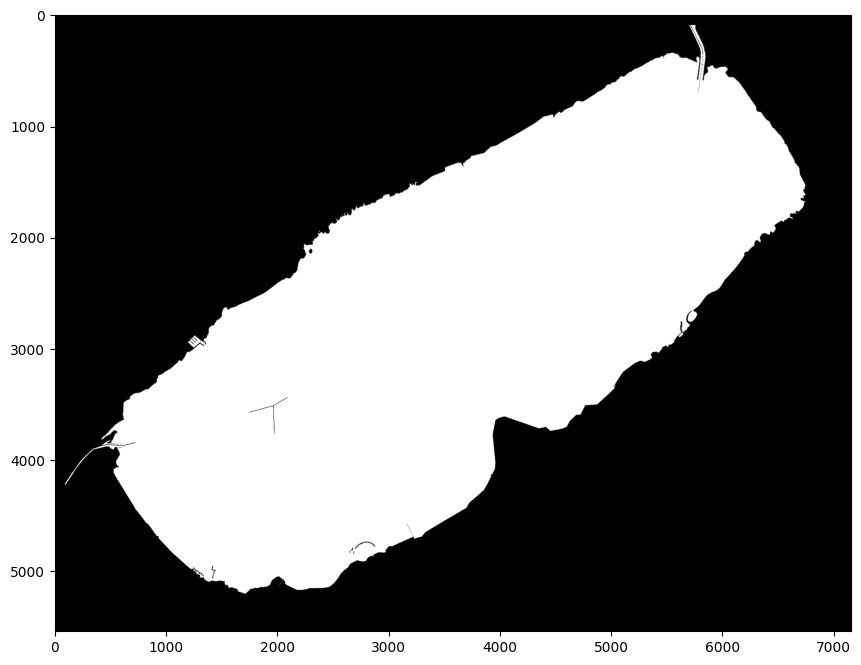

In [257]:
#count objects, calculate area of each object
n_objects, labels = cv.connectedComponents(bin_og)
print('Number of objects:', n_objects - 1)
print('Size of biggest object:', (labels == 1).sum())

#filter image keeping only the biggest object
bin = (labels == 1).astype(int)
bin = bin.astype('uint8') * 255
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(bin, cmap='gray')
plt.show()

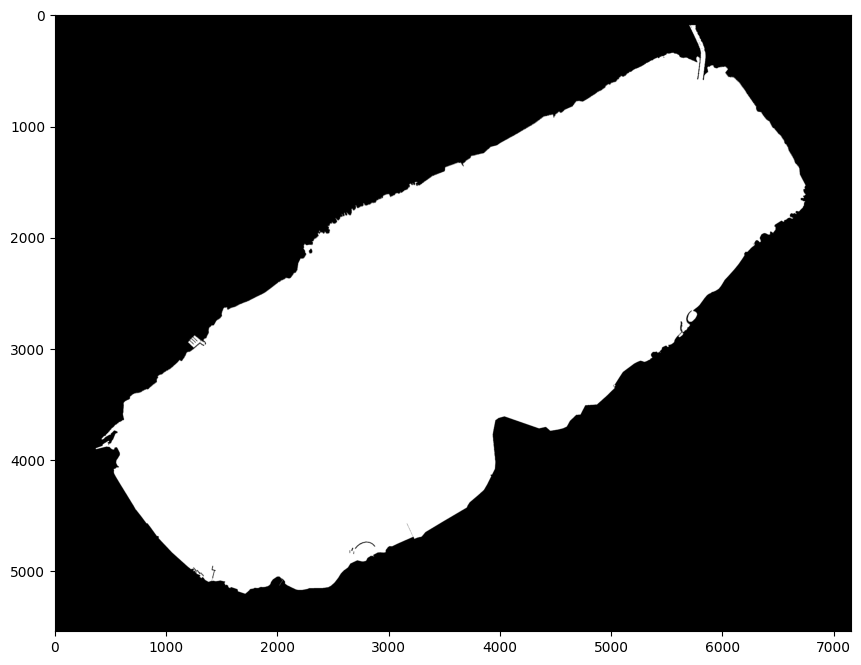

In [258]:
x_start, x_end = 1500, 2500
y_start, y_end = 3000, 4000
roi = bin[y_start:y_end, x_start:x_end]

kernel_size = (7, 7)
kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)

closed_roi = cv.morphologyEx(roi, cv.MORPH_CLOSE, kernel)

bin[y_start:y_end, x_start:x_end] = closed_roi

# 2nd ROI
x_start, x_end = 5200, 6000
y_start, y_end = 0, 1500
roi = bin[y_start:y_end, x_start:x_end]

kernel_size = (6, 2)
kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)

closed_roi = cv.morphologyEx(roi, cv.MORPH_CLOSE, kernel)

bin[y_start:y_end, x_start:x_end] = closed_roi

# 3rd ROI
x_start, x_end = 0, 1000
y_start, y_end = 3500, 4200

roi = bin[y_start:y_end, x_start:x_end]

kernel_size = (2, 6)
kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)

closed_roi = cv.morphologyEx(roi, cv.MORPH_CLOSE, kernel)

bin[y_start:y_end, x_start:x_end] = closed_roi

# 4th ROI (opening)
x_start, x_end = 0, 900
y_start, y_end = 3500, 4200

roi = bin[y_start:y_end, x_start:x_end]

kernel_size = (5, 9)
kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)

opened_roi = cv.morphologyEx(roi, cv.MORPH_OPEN, kernel)

bin[y_start:y_end, x_start:x_end] = opened_roi

#bwareaopen
def bwareaopen(img, size):
    n_objects, labels = cv.connectedComponents(img)
    for i in range(1, n_objects):
        if (labels == i).sum() < size:
            img[labels == i] = 0
    return img

bin = bwareaopen(bin, 10000)

# 3rd ROI again
x_start, x_end = 0, 1000
y_start, y_end = 3500, 4200

roi = bin[y_start:y_end, x_start:x_end]

kernel_size = (2, 8)
kernel = cv.getStructuringElement(cv.MORPH_RECT, kernel_size)

closed_roi = cv.morphologyEx(roi, cv.MORPH_CLOSE, kernel)

bin[y_start:y_end, x_start:x_end] = closed_roi


fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.imshow(bin, cmap='gray')
plt.show()

In [275]:
object_area = (bin == 255).sum() / bin.size * area_sqm/1000000
print('Size of the object:', object_area, 'km²')

actual_area = 22.497435213862826

print('Object area is', str(round(object_area/actual_area*100, 3)) + '% of the actual area')


Size of the object: 21.191779542249847 km²
Object area is 94.196% of the actual area
